In [1]:
import torch as th
import numpy as np

# Breaking down cDPM code

## `sample_some_indices`

In [63]:
def sample_some_indices(max_indices=20, T=128):
    # print("Sampling indices, T is ", T)
    s = th.randint(low=1, high=max_indices+1, size=())
    max_scale = T / (s-0.999)
    scale = np.exp(np.random.rand() * np.log(max_scale))
    pos = th.rand(()) * (T - scale*(s-1))
    # print(f"s: {s}, max_sacle: {max_scale}, pos: {pos}")
    indices = [int(pos+i*scale) for i in range(s)]
    print(indices)
    # do some recursion if we have somehow failed to satisfy the consrtaints
    if all(i<T and i>=0 for i in indices):
        return indices
    else:
        print('warning: sampled invalid indices', [int(pos+i*scale) for i in range(s)], 'trying again')
        # exit()
        return self.sample_some_indices(max_indices, T)

In [2]:
max_indices=20
T=128

In [29]:
s = th.randint(low=1, high=max_indices+1, size=())
max_scale = T / (s-0.999)
scale = np.exp(np.random.rand() * np.log(max_scale))
pos = th.rand(()) * (T - scale*(s-1))
# print(f"s: {s}, max_sacle: {max_scale}, pos: {pos}")
indices = [int(pos+i*scale) for i in range(s)]
print(f"s: {s}, max_sacle: {max_scale}, pos: {pos}")
print(f"scale: {scale}")
print(indices)

s: 12, max_sacle: 11.635305404663086, pos: 74.12855529785156
scale: 4.387874603271484
[74, 78, 82, 87, 91, 96, 100, 104, 109, 113, 118, 122]


/tmp/ipykernel_1643087/2914927780.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = np.exp(np.random.rand() * np.log(max_scale))


This function randomly samples a number of indices `s`as well as a starting position `pos` and spacing `scale` to return `s` roughly linearly spaced indices between 1 and 128.

## `sample_all_masks`

In [40]:
def sample_all_masks(self, batch1, batch2=None, gather=True, set_masks={'obs': (), 'latent': ()}):
    # print("Inside sample_all_masks")
    N = self.max_frames
    # print(f'batch1 {batch1.shape}, {batch2.shape}, {N}')
    B, T, *_ = batch1.shape
    masks = {k: th.zeros_like(batch1[:, :, :1, :1, :1]) for k in ['obs', 'latent']}
    for obs_row, latent_row in zip(*[masks[k] for k in ['obs', 'latent']]):
        latent_row[self.sample_some_indices(max_indices=N, T=T)] = 1.
        while True:
            mask = obs_row if th.rand(()) < 0.5 else latent_row
            indices = th.tensor(self.sample_some_indices(max_indices=N, T=T))
            taken = (obs_row[indices] + latent_row[indices]).view(-1)
            indices = indices[taken == 0]  # remove indices that are already used in a mask
            if len(indices) > N - sum(obs_row) - sum(latent_row):
                break
            mask[indices] = 1.
    if len(set_masks['obs']) > 0:  # set_masks allow us to choose informative masks for logging
        for k in masks:
            set_values = set_masks[k]
            n_set = min(len(set_values), len(masks[k]))
            masks[k][:n_set] = set_values[:n_set]
    any_mask = (masks['obs'] + masks['latent']).clip(max=1)
    if not gather:
        return batch1, masks['obs'], masks['latent']
    batch, (obs_mask, latent_mask), frame_indices =\
        self.prepare_training_batch(
            any_mask, batch1, batch2, (masks['obs'], masks['latent'])
        )
    return batch, frame_indices, obs_mask, latent_mask

In [150]:
N = 20 # max_frames is same as maximum number of slices?

* Makes dictionary of obs and latent masks
* In latent_row it sets sampled indices from `sample_some_indices` to one, so a one hot encoding of the condition (?) slices
* w.p. 0.5 choose mask to be the obs row otherwise the latent
* sample more indices


In [151]:
batch1 = th.zeros((1, 128, 1, 128, 128)) # B, T, C, H, W

In [152]:
masks = {k: th.zeros_like(batch1[:, :, :1, :1, :1]) for k in ['obs', 'latent']}

This makes obs and latent masks with a batch size equal to the batch size used

In [153]:
del obs_row, latent_row

In [154]:
for obs_row, latent_row in zip(*[masks[k] for k in ['obs', 'latent']]):
    print(latent_row.shape)

torch.Size([128, 1, 1, 1])


So this iterates across the batch dimension of the masks to do the code for each part of the mask in that batch

In [111]:
latent_row = masks['latent'][0]

In [112]:
latent_row[sample_some_indices(max_indices=N, T=T)] = 1

[56, 65, 74, 83, 92, 101, 109, 118, 127]


/tmp/ipykernel_1643087/3152650083.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = np.exp(np.random.rand() * np.log(max_scale))


In [113]:
indices = th.tensor(sample_some_indices())

[78, 87]


/tmp/ipykernel_1643087/3152650083.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = np.exp(np.random.rand() * np.log(max_scale))


In [114]:
indices.shape

torch.Size([2])

In [115]:
taken = (obs_row[indices] + latent_row[indices]).view(-1)

In [116]:
indices[taken == 0]

tensor([78, 87])

In [155]:
for obs_row, latent_row in zip(*[masks[k] for k in ['obs', 'latent']]):
    latent_row[sample_some_indices(max_indices=N, T=T)] = 1.
    while True:
        mask = obs_row if th.rand(()) < 0.5 else latent_row
        indices = th.tensor(sample_some_indices(max_indices=N, T=T))
        taken = (obs_row[indices] + latent_row[indices]).view(-1)
        indices = indices[taken == 0]  # remove indices that are already used in a mask
        if len(indices) > N - sum(obs_row) - sum(latent_row):
            break
        mask[indices] = 1.

[58, 61, 63, 66, 69, 71, 74, 77, 79, 82, 85, 87, 90]
[80, 82, 84, 85, 87, 89, 90, 92, 94, 96]
[71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89, 90, 92, 93, 95, 96, 97, 99]


/tmp/ipykernel_1643087/3152650083.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = np.exp(np.random.rand() * np.log(max_scale))


In [156]:
th.sum(masks['obs'][0])

tensor(0.)

In [157]:
th.sum(masks['latent'][0])

tensor(19.)

Not sure what it's doing exactly, it's used in conjunction with `prepare_training_batch` to get everything ready. Think can just do my own.

In [158]:
any_mask = (masks['obs'] + masks['latent']).clip(max=1)

In [148]:
def prepare_training_batch(mask, batch1, batch2, tensors, max_frames=20, pad_with_random_frames=False):
    """
    Prepare training batch by selecting frames from batch1 according to mask, appending uniformly sampled frames
    from batch2, and selecting the corresponding elements from tensors (usually obs_mask and latent_mask).
    """
    B, T, *_ = mask.shape
    mask = mask.view(B, T)  # remove unit C, H, W dims
    effective_T = max_frames if pad_with_random_frames else mask.sum(dim=1).max().int()
    indices = th.zeros_like(mask[:, :effective_T], dtype=th.int64)
    new_batch = th.zeros_like(batch1[:, :effective_T])
    new_tensors = [th.zeros_like(t[:, :effective_T]) for t in tensors]
    for b in range(B):
        instance_T = mask[b].sum().int()
        indices[b, :instance_T] = mask[b].nonzero().flatten()
        indices[b, instance_T:] = th.randint_like(indices[b, instance_T:], high=T) if pad_with_random_frames else 0
        new_batch[b, :instance_T] = batch1[b][mask[b]==1]
        new_batch[b, instance_T:] = (batch1 if batch2 is None else batch2)[b][indices[b, instance_T:]]
        for new_t, t in zip(new_tensors, tensors):
            new_t[b, :instance_T] = t[b][mask[b]==1]
            new_t[b, instance_T:] = t[b][indices[b, instance_T:]]
    return new_batch, new_tensors, indices


In [169]:
batch, (obs_mask, latent_mask), frame_indices = prepare_training_batch(any_mask, batch1, None, (masks['obs'], masks['latent']))

In [170]:
batch.shape

torch.Size([1, 19, 1, 128, 128])

In [171]:
obs_mask.shape

torch.Size([1, 19, 1, 1, 1])

In [172]:
latent_mask.shape

torch.Size([1, 19, 1, 1, 1])

In [173]:
frame_indices

tensor([[58, 61, 63, 66, 69, 71, 74, 77, 79, 80, 82, 84, 85, 87, 89, 90, 92, 94,
         96]])

## My own implementation

In [279]:
import random
import matplotlib.pyplot as plt

In [329]:
def sample_indices(max_slices=20, num_slices=128):

    total_indices = random.randint(1, max_slices)

    indices = random.sample(range(1,num_slices), total_indices)

    target_size = random.randint(1, len(indices))
    target = random.sample(indices, target_size)
    condition = [index for index in indices if index not in target]

    return condition, target

In [342]:
test_list = [sample_indices()[1] for i in range(100000)]

In [343]:
i = 0
singletons = []
for target in test_list:
    if len(target) == 1:
        i += 1
        singletons += target

In [344]:
i/100000

0.17942

(array([121., 125., 132., 125., 152., 127., 128., 131., 145., 129., 149.,
        122., 144., 140., 147., 146., 143., 129., 128., 158., 130., 144.,
        123., 125., 127., 147., 146., 131., 140., 140., 148., 178., 151.,
        147., 156., 145., 139., 137., 146., 139., 136., 148., 141., 128.,
        134., 135., 154., 120., 139., 138., 141., 133., 143., 168., 136.,
        153., 155., 157., 143., 138., 139., 154., 137., 141., 146., 153.,
        122., 120., 156., 138., 139., 140., 130., 143., 137., 138., 139.,
        157., 128., 145., 135., 130., 150., 150., 154., 150., 163., 142.,
        149., 143., 133., 134., 129., 150., 137., 147., 124., 136., 130.,
        143., 180., 128., 149., 141., 145., 152., 121., 141., 161., 135.,
        166., 132., 139., 130., 154., 141., 148., 133., 128., 156., 131.,
        152., 151., 146., 135., 161., 155.]),
 array([  1.        ,   1.99212598,   2.98425197,   3.97637795,
          4.96850394,   5.96062992,   6.95275591,   7.94488189,
          8.

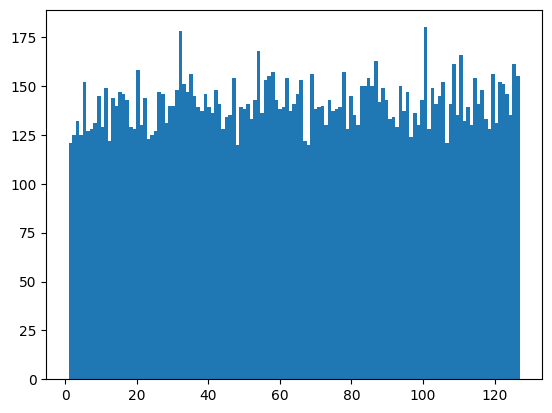

In [346]:
plt.hist(singletons, bins=127)

In [349]:
singletons.count(127)

155

In [318]:
condition, target = sample_indices()

In [326]:
sorted(condition)

[6, 27, 42, 58, 74, 122, 125]

In [319]:
encoding = np.zeros(128)

In [323]:
encoding[condition] = 1

In [324]:
encoding[target] = 2

In [351]:
batch1.shape

torch.Size([1, 128, 1, 128, 128])

## Testing batch manipulation

In [352]:
test_batch = th.zeros(3,128,128,128)

In [359]:
condition

[6, 122, 58, 42, 27, 125, 74]

In [362]:
test_batch[:, condition].shape

torch.Size([3, 7, 128, 128])

In [365]:
target

[100, 116]

In [364]:
test_batch[:, target].shape

torch.Size([3, 2, 128, 128])